In [1]:
%matplotlib inline
%load_ext Ddip
%makedip -a fastai_v1 -g all

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


In [2]:
%%dip everywhere
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [3]:
path = Config().data_path()/'mnist'

In [4]:
path.ls()

[PosixPath('/home/ndim1/.fastai/data/mnist/mnist.pkl.gz')]

In [5]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

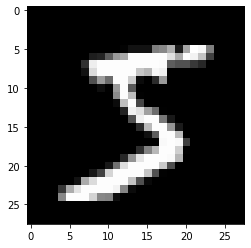

In [6]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [7]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [8]:
%dipush x_train y_train x_valid y_valid
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip


In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [9]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [10]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

Out[0:3]: (torch.Size([64, 784]), torch.Size([64]))

In [11]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [12]:
model = Mnist_Logistic().cuda()

In [13]:
model

Out[0:6]: 
Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
model.lin

Out[0:7]: Linear(in_features=784, out_features=10, bias=True)

In [15]:
model(x).shape

Out[0:8]: torch.Size([64, 10])

In [16]:
[p.shape for p in model.parameters()]

Out[0:9]: [torch.Size([10, 784]), torch.Size([10])]

In [17]:
lr=2e-2

In [18]:
loss_func = nn.CrossEntropyLoss()

In [19]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [20]:
losses = [update(x,y,lr) for x,y in data.train_dl]

[output:0]

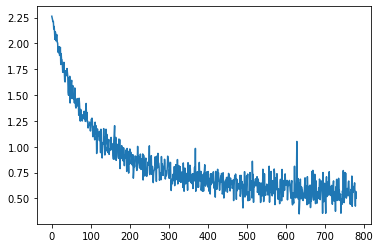

In [21]:
plt.plot(losses);

In [22]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [23]:
model = Mnist_NN().cuda()

In [24]:
losses = [update(x,y,lr) for x,y in data.train_dl]

[output:0]

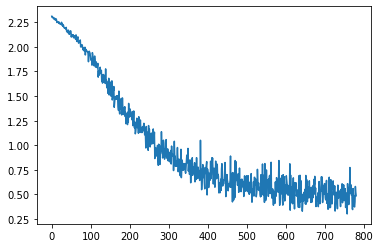

In [25]:
plt.plot(losses);

In [26]:
model = Mnist_NN().cuda()

In [27]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [28]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

[output:0]

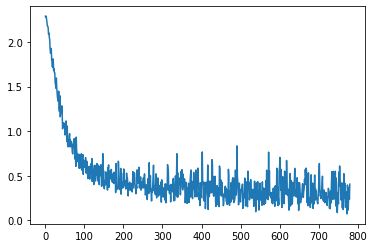

In [29]:
plt.plot(losses);

In [30]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch     train_loss  valid_loss  accuracy  time    
0         2.598740    #na#        00:00     ---------| 11.14% [87/781 00:00<00:04 2.1008]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


[output:0]

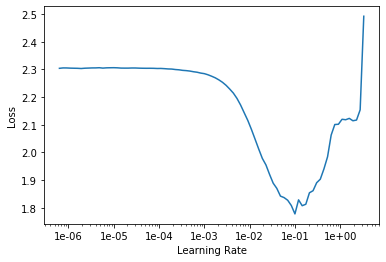

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2)

epoch     train_loss  valid_loss  accuracy  time    
0         0.232371    0.159536    0.952210  00:02                                          


[output:0]

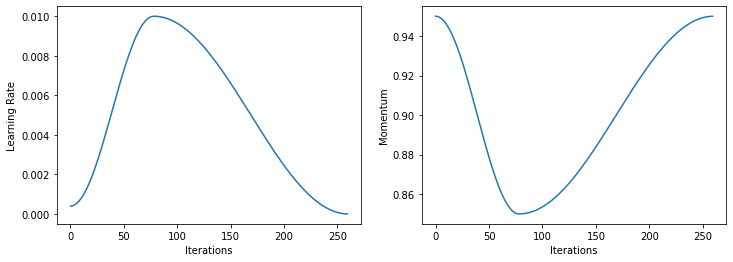

In [33]:
learn.recorder.plot_lr(show_moms=True)

[output:0]

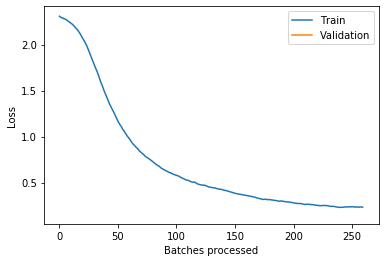

In [34]:
learn.recorder.plot_losses()

## fin